<a href="https://colab.research.google.com/github/kimbob123/Fintech2024-1/blob/main/(9)_NLP_LSTM***.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#시작

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [3]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [4]:
import pkg_resources

# 확인할 패키지 리스트
packages_to_check = [
    "datasets",
    "ipykernel",
    "ipython",
    "numpy",
    "pandas",
    "pytz",
    "torch",
    "torchaudio",
    "torchtext",
    "torchvision",
    "tqdm"
]

# 설치된 패키지의 이름과 버전 출력
installed_packages = pkg_resources.working_set
for package in installed_packages:
    if package.project_name in packages_to_check:
        print(f"{package.project_name}=={package.version}")


ipykernel==5.5.6
ipython==7.34.0
numpy==1.25.2
pandas==2.0.3
pytz==2023.4
torch==2.3.0+cu121
torchaudio==2.3.0+cu121
torchtext==0.18.0
torchvision==0.18.0+cu121
tqdm==4.66.4


In [5]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#전처리

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [7]:
train_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [8]:
train_data

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [9]:
def assign_label(row):
    if row['winner_tie'] == 1:
        return 1, 1, row['response_a'], row['response_b']
    elif row['winner_model_a'] == 1:
        return 2, 0, row['response_a'], row['response_b']
    elif row['winner_model_b'] == 1:
        return 0, 2, row['response_a'], row['response_b']

# 'assign_label' 함수를 적용하여 'label'과 'response' 열 생성
train_data['label_a'], train_data['label_b'], train_data['response_a'], train_data['response_b'] = zip(*train_data.apply(assign_label, axis=1))

# 필요한 열만 선택 후 id와 response_a, response_b를 다루어 새로운 데이터프레임 생성
response_a_df = train_data[['id', 'response_a', 'label_a']].rename(columns={'response_a': 'response', 'label_a': 'label'})
response_b_df = train_data[['id', 'response_b', 'label_b']].rename(columns={'response_b': 'response', 'label_b': 'label'})
train_data = pd.concat([response_a_df, response_b_df], ignore_index=True)
print(train_data['response'][57476])
print(train_data['response'][57477])

["27 apples"]
["As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of gender quotas in managerial positions is a complex one and positions can vary. Advocates argue that such measures can help correct historical imbalances, promote diversity, and may lead to better decision-making. Critics may argue that positions should be based purely on merit, and that quotas could potentially lead to tokenism or unqualified candidates being promoted. Morality can be subjective and differs from person to person based on their personal beliefs, cultural background, and values. It's a topic with valid arguments on both sides, and it's up to each individual or organization to decide what they believe is right.","As an AI, I don't eat, so I don't have personal preferences. But, in the world of pizza, the pineapple topping is a hotly debated topic! Some people love the sweet and savory mix it brings to a pizza, a flavor combination made famous by the Hawaiian p

In [10]:
print(train_data['response'][57475])
print(train_data['response'][57476])
print('====위까지 a, 아래부터 b====')
print(train_data['response'][57477])
print(train_data['response'][57478])
print(train_data['response'][57479])

["Bromadiolone is a rodenticide which is most often used in bait. It is a second generation anticoagulant that blocks the production of vitamin K1, which is essential for blood clotting. Without vitamin K1, the blood will not clot properly and the rat will bleed to death. Bromadiolone is effective at killing rats in a matter of hours and is often used in areas where rats are a problem, such as around homes, businesses, and farms."]
["27 apples"]
====위까지 a, 아래부터 b====
["As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of gender quotas in managerial positions is a complex one and positions can vary. Advocates argue that such measures can help correct historical imbalances, promote diversity, and may lead to better decision-making. Critics may argue that positions should be based purely on merit, and that quotas could potentially lead to tokenism or unqualified candidates being promoted. Morality can be subjective and differs from person to pe

## 토큰화

In [11]:
train_data = datasets.Dataset.from_pandas(train_data)

changed in 3 = nltk!!

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

자 어근만 추출하는 것추가

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLTK의 WordNetLemmatizer 및 불용어 목록 로드
lemmatizer = WordNetLemmatizer()
tokenizer = word_tokenize
stop_words = set(stopwords.words("english"))

def nltk_tokenize_example(example, max_length):
    # 문장을 토큰화
    tokens = tokenizer(example["response"])[:max_length]

    # 불용어 제거 및 토큰들을 소문자로 변환
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

    # 토큰들을 원형으로 변환 #
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    length = len(tokens)
    return {"tokens": tokens, "length": length}

max_length = 1000

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
train_data = train_data.map(
    nltk_tokenize_example, fn_kwargs={"max_length": max_length}
)

Map:   0%|          | 0/114954 [00:00<?, ? examples/s]

In [17]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [18]:
len(train_data), len(valid_data)

(86215, 28739)

## Vocab 만들기

In [19]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]
from torchtext.vocab import Vocab
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [20]:
len(vocab)

212994

In [21]:
vocab.get_itos()[:10]


['<unk>', '<pad>', ',', '.', "''", ':', '*', ')', '(', '``']

In [22]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

## 숫자화

In [23]:
vocab.set_default_index(unk_index) #이거 없으면 numericalize 안돌아감 ;;

In [24]:
#여기서 글자를 숫자로 만드는구나...
def numericalize(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [25]:
train_data = train_data.map(numericalize, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/86215 [00:00<?, ? examples/s]

Map:   0%|          | 0/28739 [00:00<?, ? examples/s]

## 토치화

In [26]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", 'length'])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", 'length'])

In [27]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [28]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [29]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)

In [30]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

.vector_cache/glove.840B.300d.zip: 2.18GB [06:55, 5.24MB/s]                            
100%|█████████▉| 2196016/2196017 [04:04<00:00, 8987.49it/s]


# 모델! LSTM

In [33]:
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        additional_linear_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,  # pad_index 매개변수 추가
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, additional_linear_dim)
        self.fc2 = nn.Linear(additional_linear_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.tanh = nn.Tanh()

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        hidden = self.tanh(hidden)
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        prediction = self.fc2(hidden)
        prediction = F.softmax(prediction, dim=-1)
        return prediction



레이어 늘리고 차원도 늘림

In [34]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 128
output_dim = len(train_data.unique("label"))
n_layers = 5
bidirectional = True
dropout_rate = 0.5
additional_linear_dim = 10

lstm_model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(lstm_model):,} trainable parameters")

The model has 65,922,179 trainable parameters


In [36]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [37]:
lstm_model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(212994, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (tanh): Tanh()
)

In [38]:
lstm_model.embedding.weight.data = pretrained_embedding

In [39]:
lr = 5e-4

optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [40]:
# cuda 사용함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [42]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [43]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [44]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

#LSTM 학습 & Val 평가

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.to(device)

LSTM(
  (embedding): Embedding(212994, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (tanh): Tanh()
)

In [46]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, lstm_model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, lstm_model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), "base_lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.09it/s]


epoch: 0
train_loss: 1.095, train_acc: 0.360
valid_loss: 1.089, valid_acc: 0.382


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.08it/s]


epoch: 1
train_loss: 1.088, train_acc: 0.379
valid_loss: 1.082, valid_acc: 0.392


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.07it/s]


epoch: 2
train_loss: 1.076, train_acc: 0.404
valid_loss: 1.078, valid_acc: 0.401


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.07it/s]


epoch: 3
train_loss: 1.056, train_acc: 0.435
valid_loss: 1.076, valid_acc: 0.408


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.08it/s]


epoch: 4
train_loss: 1.031, train_acc: 0.470
valid_loss: 1.081, valid_acc: 0.402


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.06it/s]


epoch: 5
train_loss: 1.006, train_acc: 0.504
valid_loss: 1.079, valid_acc: 0.406


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.07it/s]


epoch: 6
train_loss: 0.980, train_acc: 0.540
valid_loss: 1.091, valid_acc: 0.405


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.07it/s]


epoch: 7
train_loss: 0.959, train_acc: 0.567
valid_loss: 1.092, valid_acc: 0.403


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.06it/s]


epoch: 8
train_loss: 0.937, train_acc: 0.596
valid_loss: 1.110, valid_acc: 0.401


evaluating...: 100%|██████████| 57/57 [00:11<00:00,  5.09it/s]

epoch: 9
train_loss: 0.917, train_acc: 0.618
valid_loss: 1.115, valid_acc: 0.408


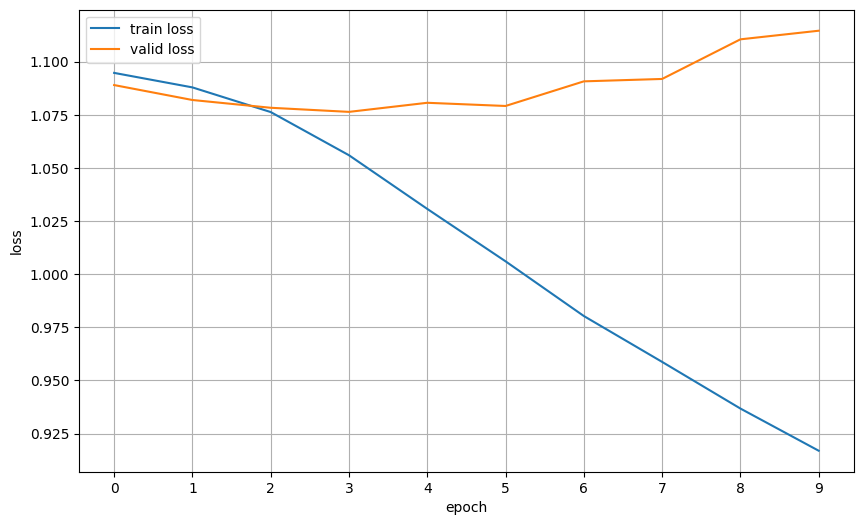

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

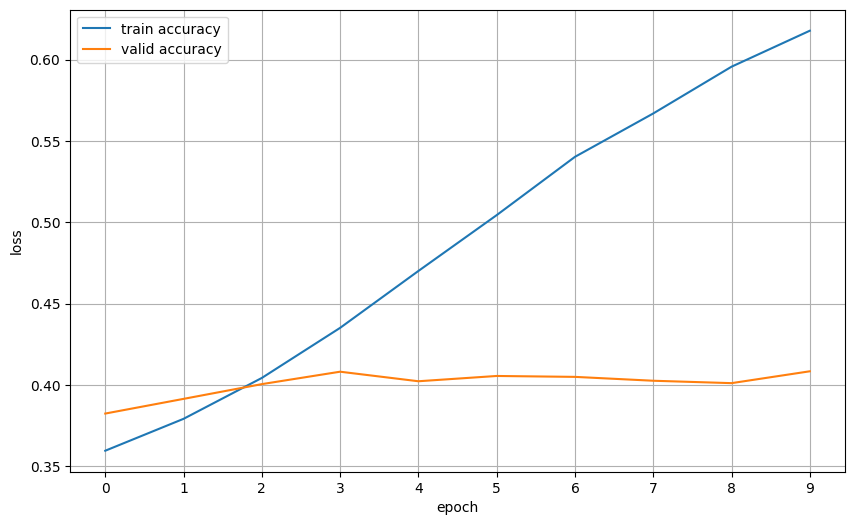

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
# Given values
train_losses = [1.092, 1.080, 1.061, 1.031, 1.002, 0.974, 0.948, 0.924, 0.902, 0.883]
valid_losses = [1.084, 1.080, 1.077, 1.074, 1.084, 1.087, 1.101, 1.108, 1.111, 1.116]
train_accs = [0.365, 0.395, 0.430, 0.472, 0.511, 0.548, 0.579, 0.608, 0.634, 0.655]
valid_accs = [0.391, 0.397, 0.404, 0.407, 0.400, 0.407, 0.408, 0.406, 0.404, 0.404]

# Calculate the averages
avg_train_loss = np.mean(train_losses)
avg_valid_loss = np.mean(valid_losses)
avg_train_acc = np.mean(train_accs)
avg_valid_acc = np.mean(valid_accs)

# Print the results
print(f'Average Training Loss: {avg_train_loss:.4f}')
print(f'Average Validation Loss: {avg_valid_loss:.4f}')
print(f'Average Training Accuracy: {avg_train_acc:.4f}')
print(f'Average Validation Accuracy: {avg_valid_acc:.4f}')
